##### Here we're going to do some dimensionality reduction on the data before clustering. We'll use the same code from last time to read the data into our numpy array

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import sys; sys.path.insert(0,'C:/Users/Micah/Documents/clustering_for_dummies/ca45_clustering_imports')
import fileread as fr; import wave_ops as wo; import predefined as pd

In [3]:
runs=[run for run in os.listdir('C:/Users/Micah/Documents/clustering_for_dummies')       if run.endswith('.bin') and run[4:-6]!='186']
runs.sort()
print(runs)
path='C:/Users/Micah/Documents/clustering_for_dummies/'
proc_data=fr.gen_output(path+'Run_60-all.dat')[0]

bdch=11#35
bd,ch=divmod(bdch,8)
cal=pd.calibration[(pd.calibration.board==bd)*(pd.calibration.channel==ch)][0]


mn,mx=0,1460
t=(proc_data.board==bd)*(proc_data.channel==ch)*(proc_data.energy<mx)
proc_data=proc_data[t]

['Run_60_0.bin']


In [4]:
wfs=[]
path='C:/Users/Micah/Documents/clustering_for_dummies/'

for run in runs:
    numwaves=int((os.stat(path+run).st_size-8)/(7033))
    numwaves=20000
    data=fr.raw(path+run,length=3500,numwaves=numwaves,row=1000).view(np.recarray)
    t=(data.board==bd)*(data.channel==ch)
    data=data[t]
    wo.baseline_restore(data,pretrigger=600)
    maxes=np.amax(data.wave,axis=1)
    t=(maxes>mn)*(maxes<mx)
    data=data[t]
    tot=len(proc_data)
    for i,stamp in enumerate(proc_data.timestamp):
        if divmod(i,100)[1]==0:
            print('\r'+30*' ',end='')
            print('\r'+'{:0d}% of '.format(int(100*i/tot))+run,end='')
        l=np.nonzero(data.timestamp==stamp)[0]
        if l.shape[0]>0:
            wfs.append(data[l[0]])

wfs=np.asarray(wfs).view(np.recarray)

99% of Run_60_0.bin           

In [5]:
X=wfs.wave[0:len(wfs)].copy().astype('f4')

In [6]:
x_norm = np.zeros_like(X)

In [7]:
def normBatch(x):
    for i in range(len(x)):
        x_norm[i] = x[i] - np.amin(x[i])
        x_norm[i] = x_norm[i]*2./np.amax(x[i])
        x_norm[i] = x_norm[i] - 1

In [8]:
normBatch(X)

##### To dimensionality reduce, we will use a method called Principal Component Analysis. The goal of this is to find a new orthogonal space to describe our data in with fewer dimensions, while still capturing most of the variance in the data.

##### To perform PCA, we will use a Singular Value Decomposition. This breaks our data matrix up into a product of three matrices: U, S, and Vh. The columns of U and V are orthonormal bases, and S is a diagonal matrix containing the singular values in descending order. The square of the singular value corresponds to the variance contained in that principal component.

In [9]:
u, s, vh = np.linalg.svd(x_norm, full_matrices=False)

##### We can look at what some of the new basis vectors look like now.

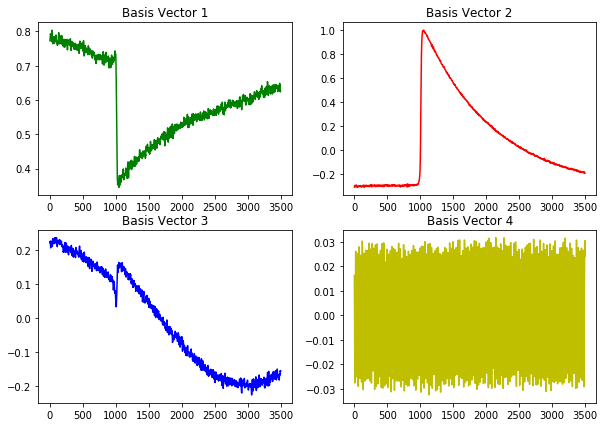

In [11]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
ax[0,0].plot(u[0,0]*s[0]*vh[0], color = 'g')
ax[0,0].title.set_text("Basis Vector 1")
ax[0,1].plot(u[1,1]*s[1]*vh[1], color = 'r')
ax[0,1].title.set_text("Basis Vector 2")
ax[1,0].plot(u[2,2]*s[2]*vh[2], color = 'b')
ax[1,0].title.set_text("Basis Vector 3")
ax[1,1].plot(u[3,3]*s[3]*vh[3], color = 'y')
ax[1,1].title.set_text("Basis Vector 4")

##### Now we need to decide how many dimensions to cut down to. One way of determining this is to make a scree plot. We can plot the singular values on the y axis, and their order on the axis, and then look for an elbow to find a good cutoff point. 

In [12]:
scree_order = np.arange(1,len(s)+1)

##### Here I've zoomed in on just the first 10 dimensions. And we can already see the elbow appearing here.

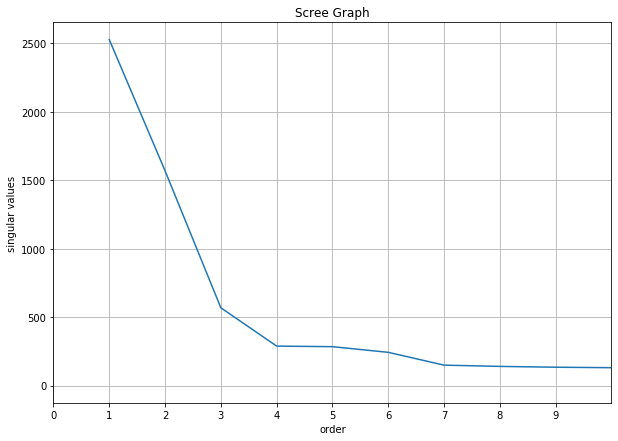

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, s)
ax.title.set_text("Scree Graph")
ax.set_ylabel("singular values")
ax.set_xlabel("order")
ax.set_xlim([0,10])
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

##### Let's also look at another graph, which will be the cumulative variance explained vs the number of dimensions. Remember, the variance explained by a dimension is given by the square of the corresponding singular value.

In [14]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]

In [15]:
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance

##### And now here we can see that we have explained 83% of the data with just 2 dimensions. I will make the cut down to a 2D space, but you should try working with different dimensionalities and see if you get different results.

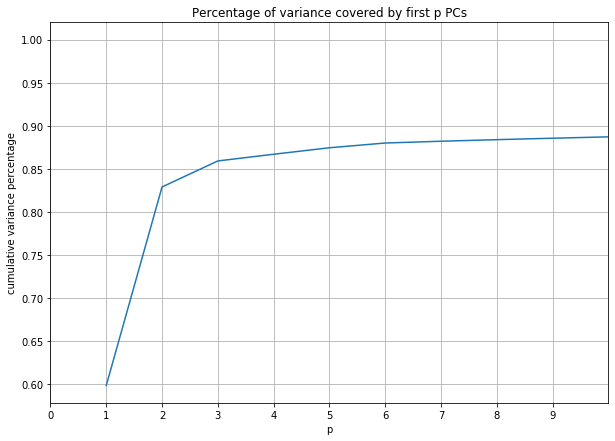

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, pvc)
ax.title.set_text('Percentage of variance covered by first p PCs')
ax.set_xlabel('p')
ax.set_ylabel('cumulative variance percentage')
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

##### Now it's time to make the cuts, which is quite simple. I formed 3 different examples here, just to show you how to make the dimensionality cut. v1 will be our transformation matrix to 2D space, v2 will transform to 4D space, and v3 will transform to 7D space.

In [17]:
v = np.transpose(vh)
v1 = v[:,:2]
v2 = v[:,:4]
v3 = v[:,:7]

In [18]:
reduced_data1 = x_norm@v1
reduced_data2 = x_norm@v2
reduced_data3 = x_norm@v3

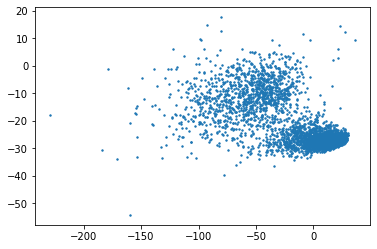

In [19]:
plt.scatter(reduced_data1[:,0], reduced_data1[:,1], s=2)

##### And now we'll do the same kmeans clustering, but this time on the 2D data. Let's see if we get anything different.

In [20]:
inertias = []
for k in range(2,20):
    kmeans = KMeans(n_clusters = k, random_state = 0, n_jobs = -1).fit(reduced_data1)
    inertias.append(kmeans.inertia_)

##### And right away you can see how much quicker the clustering was with 2 dimensions vs 3500.

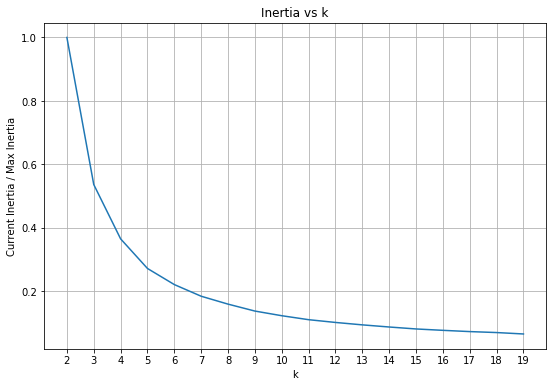

In [21]:
k = np.arange(2,20)
fig, ax = plt.subplots(1,1, figsize = (9,6))
ax.plot(k, inertias/inertias[0])
ax.title.set_text("Inertia vs k")
ax.set_xlabel("k")
ax.set_ylabel("Current Inertia / Max Inertia")
ax.set_xticks(np.arange(2,20))
plt.grid()
plt.show()

In [22]:
kmeans = KMeans(n_clusters = 8, random_state = 0, n_jobs = -1).fit(reduced_data1)

In [23]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
counts = np.zeros(8)
for i in range(8):
    for label in labels:
        if label == i:
            counts[i] += 1

In [24]:
percentage_counts = counts/len(X)
for i in range(len(percentage_counts)):
    percentage_counts[i] = round(percentage_counts[i], 3)

In [25]:
colors = {}
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'b'
colors[3] = 'c'
colors[4] = 'm'
colors[5] = 'y'
colors[6] = 'pink'
colors[7] = 'purple'

##### And here are the waveforms contained in each cluster.

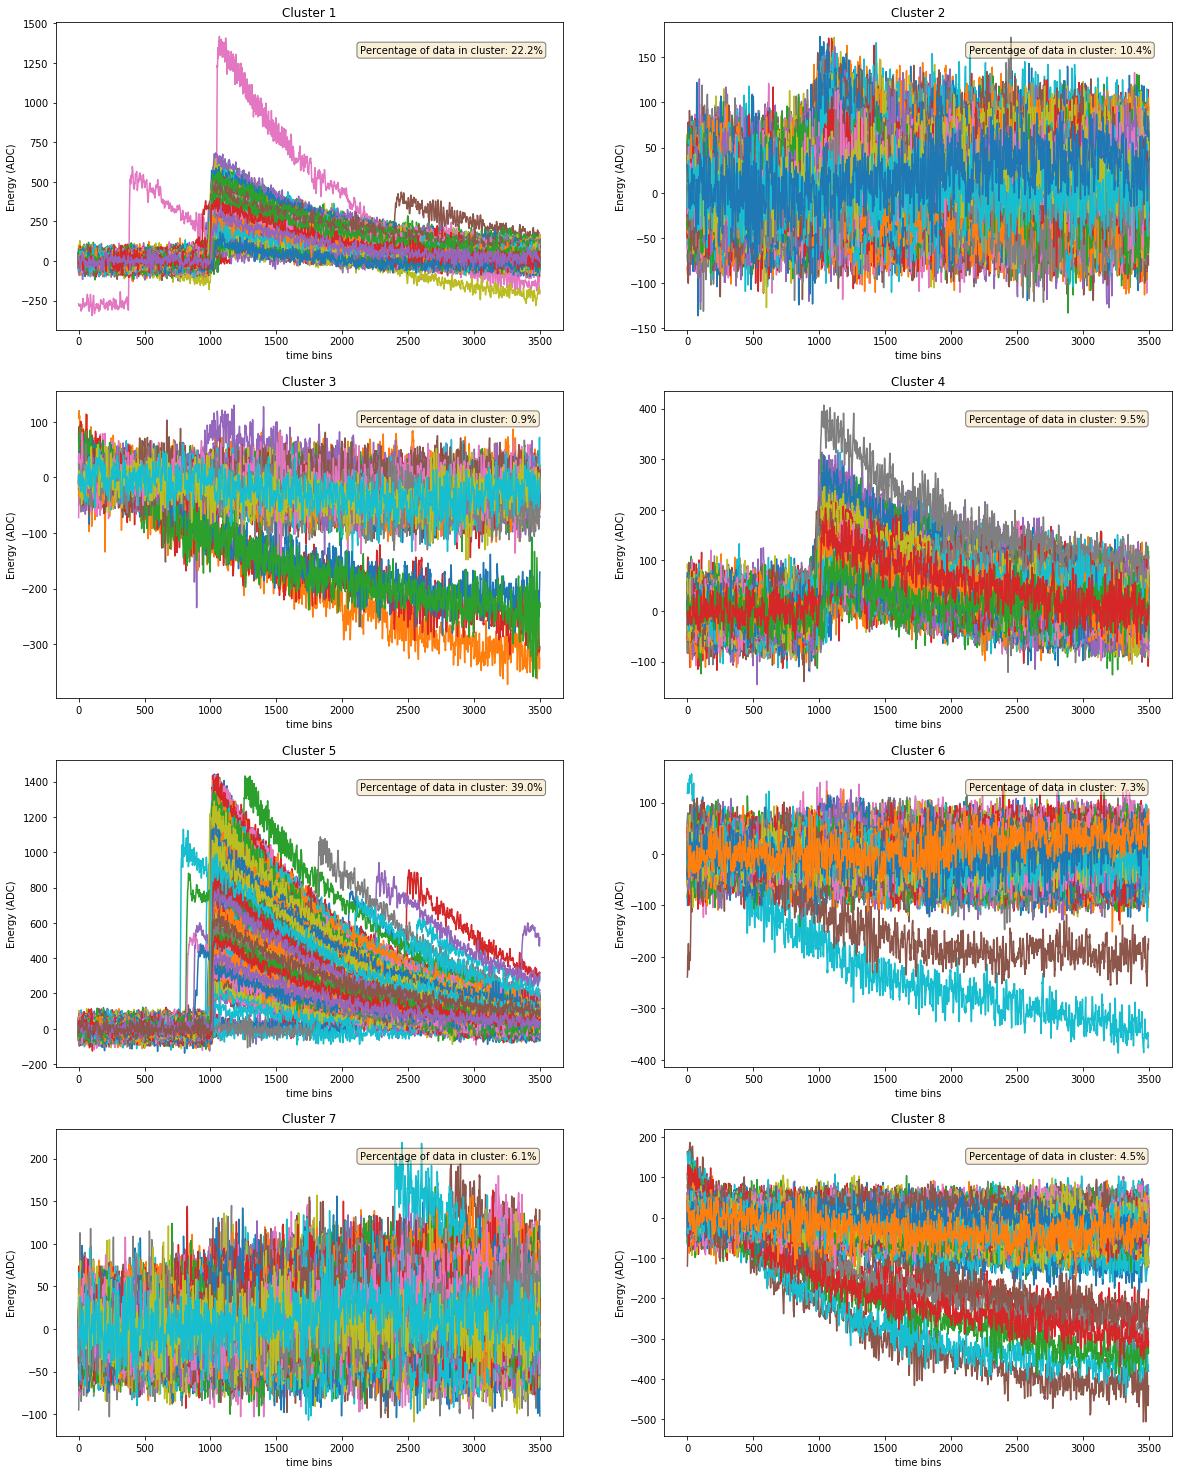

In [27]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(4, 2, figsize = (20,26))
t = np.arange(3500)
for n in range(len(labels)):
    for i in range(4):
        for j in range(2):
            k = 2*i+j+1
            if k-1 == labels[n]:
                ax[i,j].plot(t, X[n])
                ax[i,j].title.set_text("Cluster " + str(k))
                ax[i,j].set_xlabel("time bins")
                ax[i,j].set_ylabel("Energy (ADC)")
for i in range(4):
    for j in range(2):
        k = 2*i+j+1
        text_x = ax[i,j].get_xlim()[1] - 0.4*(ax[i,j].get_xlim()[1] - ax[i,j].get_xlim()[0])
        text_y = ax[i,j].get_ylim()[1] - 0.1*(ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0])
        ax[i,j].text(text_x, text_y, "Percentage of data in cluster: " + str(round(100*percentage_counts[k-1], 3)) + "%", bbox = props)
plt.show()

##### So now we can look at our clustering in our 2D space. This is a way of quality checking our clustering results. So with our choice for k=8, we can see that it doesn't seem to describe the geometry of the data very well. You can see that our final clusters look quite similar to our final clusters from last time, when we didn't dimensionality reduce. However, now we have some guidance as to how to adjust k and better cluster the data.

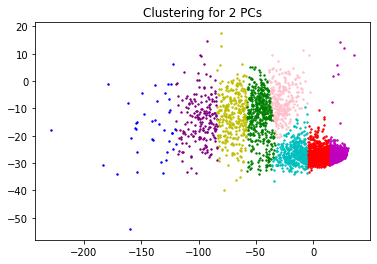

In [30]:
cvec = [colors[label] for label in labels]
x = reduced_data1[:,0]
y = reduced_data1[:,1]
fig, ax = plt.subplots()
for i in range(len(x)):
    ax.scatter(x[i],y[i], c = cvec[i], s=2)
ax.title.set_text('Clustering for 2 PCs')
plt.show()

##### So as an extension to this, try to cluster this data so that it better represents the geometry of the data set. 

##### Lastly, I'll leave you with the wikipedia entry on the curse of dimensionality, which explains why we should be wary about doing machine learning tasks in very high dimensional spaces.

##### *The curse of dimensionality refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces (often with hundreds or thousands of dimensions) that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience. The expression was coined by Richard E. Bellman when considering problems in dynamic programming.*

##### *Cursed phenomena occur in domains such as numerical analysis, sampling, combinatorics, machine learning, data mining and databases. The common theme of these problems is that when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance. In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality. Also, organizing and searching data often relies on detecting areas where objects form groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data organization strategies from being efficient.*